# Wrangle OpenStreetMap Data: Irving, Texas, USA

For this project, I've selected a portion of Irving city, located in the state of Texas of the United States of America. The actual area selected is actually the area which I am considering for a house purchase. 

Irving, TX, USA: https://en.wikipedia.org/wiki/Irving,_Texas 

The goals of this project are:
1. To extract data from an XML file;
2. To identify data inconsistencies and rectify them, if possible;
3. To investigate interesting findings based on queries. 

#### Irving, TX
As indicated on the map below, Irving city is located north west of Dallas downtown. West of Irving is the Dallas Fort Worth aiport. The square area in blue is as estimated area selected for this project. 

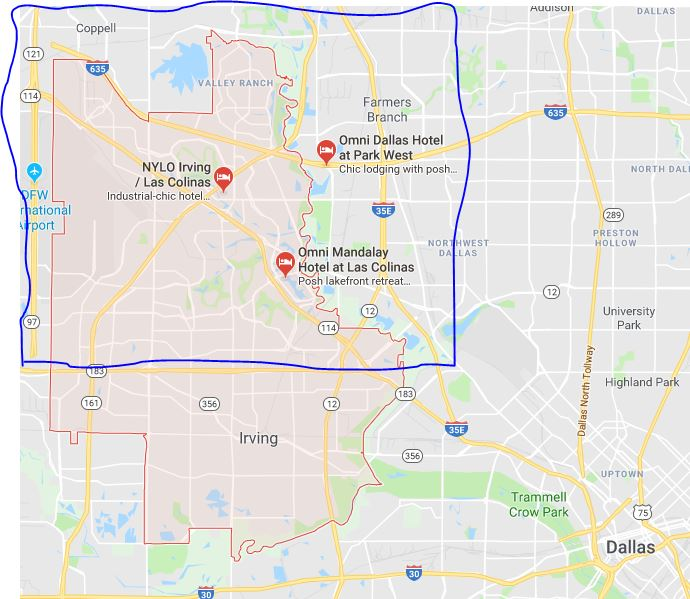

In [1]:
from IPython.display import Image
Image("img/IrvingTX.jpg")

## Package & Data Reading

First, I prepped the notebook with basic and expected packages. We may add other packages later on as needs arise. 

In [2]:
import os
import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import pprint
import numpy
import pandas
import codecs 
import json
import sqlite3
import urllib

In [3]:
# After obtaining the map file from OpenStreetMap, it's time to read the data 
# for data cleaning and basic analysis.
osm_file = "C:\Users\FA279J\Documents\Python\irving.osm" 
sample_file = "sample_osm"
def count_tags(osm_file):
    tags = {}
    for event, elem in ET.iterparse(osm_file):
        if elem.tag not in tags:
            tags[elem.tag] = 1
        else:
            tags[elem.tag] += 1
    return tags

In [4]:
# Did I manage to read the data? If so, how do the data look like?
tags = count_tags(osm_file)
pprint.pprint(tags)

{'bounds': 1,
 'member': 9305,
 'meta': 1,
 'nd': 264778,
 'node': 231703,
 'note': 1,
 'osm': 1,
 'relation': 175,
 'tag': 106704,
 'way': 23602}


Finally, I am able to figure out the way to read the .osm data. Believe it or not, I got stuck on figuring this out. The example in the Udacity lecture did not allude to reading data from my own computer drive. 

So, this may be a very small step, but I was elated to get pass this stage. 

## File Sampling

Sampling the large .osm file enables me to clean the data faster, though, with a smaller dataset. I am blessed with a good computer that I never needed to utilize this sampled file for this project. In real life, I may need to to employ this method. For instance, I may need toclean and  analyze a huge database from a Big Data cloud server.

In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

k = 50 # Parameter: take every k-th top level element

def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag

    Reference:
    http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
    """
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

with open(sample_file, 'wb') as output:
    # The text coding needs to be converted to UTF-8 version
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')

    # Write every kth top level element
    for i, element in enumerate(get_element(osm_file)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))

    output.write('</osm>')



When I selected the .osm file, I had to do a few iterations because the initial area of interest had a file size smaller that the required file size of greater than 50 MB. Based on the run below, I can confirm that the file size is 50.1 MB while I noticed that the sample file size changes as I alter the sampling unit parameter, k.

In [6]:
#check file size
#resource: http://stackoverflow.com/questions/2104080/how-to-check-file-size-in-python

def convert_bytes(num):
    """
    this function will convert bytes to MB.... GB... etc
    """
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num < 1024.0:
            return "%3.1f %s" % (num, x)
        num /= 1024.0

def file_size(file_path):
    """
    this function will return the file size
    """
    if os.path.isfile(file_path):
        file_info = os.stat(file_path)
        return convert_bytes(file_info.st_size)
    
print "The full OpenStreetMap file is", file_size(osm_file)
print "while its sample file size is", file_size(sample_file), ","
print "for records systematically selected every", k, "th (top) row."

The full OpenStreetMap file is 50.1 MB
while its sample file size is 1.0 MB ,
for records systematically selected every 50 th (top) row.


## Data Cleaning

### Street Name Cleaning

Let's clean the streetmap data. We'll be starting with street name standardization. Other map data cleaning covers zipcode.

For street name data cleaning, the obvious data normalization involves spelling out short forms or abbreviations and inserting "Highway" for highway roads. City, State, and Federal highways in the U.S. are usually noted with codes and numbers without the word "highway". 

In the auditing process, I noticed that a few abbreviations are causing issue. For instance, "St:Street" and "Dr:Drive" result in corrected "StStreet" and "DrDrive", respectively. I would spend mor time on this if given more time on this project. 

In addtion, if I had more time, I would attempt to clean and figure out a convention for street type not found in the expected street suffix list. Some of the unexpected street suffix are: 'Camilla', 'Cima', 'Clemente', 'Deseo', 'Middlefork', 'Nest', 'Redondo' and 'Rio'. I suspect many of these names are apartment complex names and subdivision names while a few others are potentially Spanish street suffix such as "Rio" (River) and "Lago" (Lake). The Spanish suffix street names are expected given that Texas borders Mexico and Texas' historical Spain and Mexico connections. See map below. 

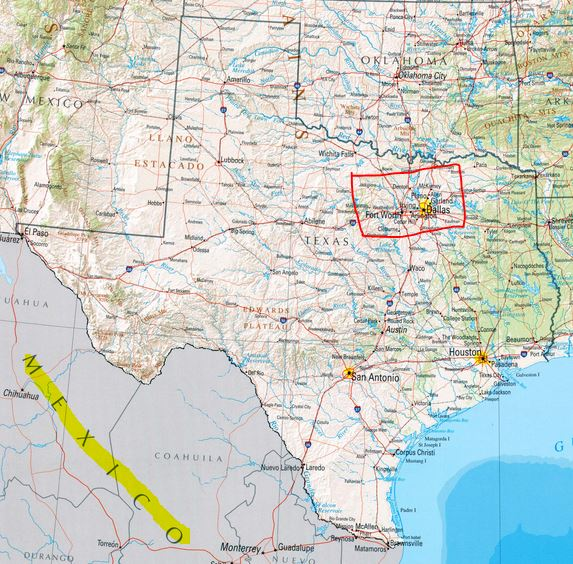

In [7]:
Image("img/TX.jpg")

In [8]:
# Standardizing and Improving Street Names
"""
This set of functions looks for suspect streets name and standardize them. 
After identifying street names based on tagging information, 
the program identify street name types based on their suffix, 
i.e. the last word for the street name values.

Street name standardization and improvements are performed in two main ways: 
correcting the suffix and manual fix.
The fixes are then applied to the data later on in shape_element().
"""

# Regular expression
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

### Street suffix - Wikipedia; https://en.wikipedia.org/wiki/Street_suffix
expected = ["Alley","Annex","Arcade","Avenue","Bayou","Beach","Bend","Bluff","Bottom","Boulevard",
            "Branch","Bridge","Brook","Burg","Bypass","Camp","Canyon","Cape","Causeway","Center",
            "Circle","Cliff","Club","Common","Corner","Course","Court","Cove","Creek","Crescent",
            "Crest","Crossing","Crossroad","Curve","Dale","Dam","Divide","Drive","Estate",
            "Expressway","Extension","Fall","Ferry","Field","Flat","Ford","Forest","Forge","Fork",
            "Fort","Freeway","Garden","Gateway","Glen","Green","Grove","Harbor","Haven","Heights",
            "Highway","Hill","Hollow","Inlet","Island","Isle","Junction","Key","Knoll","Lake","Land",
            "Landing","Lane","Light","Loaf","Lock","Lodge","Loop","Mall","Manor","Meadow","Mews","Mill",
            "Mission","Motorway","Mount","Mountain","Neck","Orchard","Oval","Overpass","Park","Parkway",
            "Pass","Passage","Path","Pike","Pine","Place","Plain","Plaza","Point","Port","Prairie",
            "Radial","Ramp","Ranch","Rapid","Rest","Ridge","River","Road","Route","Row","Rue","Run",
            "Shoal","Shore","Skyway","Spring","Spur","Square","Station","Stravenue","Stream","Street",
            "Summit","Terrace","Throughway","Trace","Track","Trafficway","Trail","Trailer","Tunnel",
            "Turnpike","Underpass","Union","Valley","Viaduct","View","Village","Ville","Vista","Walk",
            "Wall","Way","Well","Wells",
            "Tollway"]

"""
Names to be corrected andtheir corrected names
Problematic name: Corrected name
This mapping from problematic to corrected names is used
to convert problematic or unstandardized names/phrases/addresses
to corrected ones.
"""
mapping = { # "St": "Street",
            "Ave": "Avenue", "Ave.": "Avenue",
            "Blvd.": "Boulevard", "Blvd": "Boulevard",
            "Las Colinas Blvd E":"E Las Colinas Boulevard",
            "Dr.": "Drive", " Dr": " Drive", 
            "W Pioneer Dr": "W Pioneer Drive",
            "Golden Gate Dr.":"Golden Gate Drive","1421 Golden Gate Dr.":"1421 Golden Gate Drive",
            "I-635": "I-635 Interstate Highway",
            "Ln":"Lane", "Pkwy":"Parkway",
            "Rd.": "Road"," Rd": " Road",
            "St.": "Street",
            "Francis St": "Francis Street",
            "North Loop 12":"US 12 Highway",
            "North Highway 121":"US 121 Highway", 
            "State Hwy 121":"US 121 Highway",
            "Business 121":"US 121 Highway",
            "E Sandy Lake Rd #140":"#140 E Sandy Lake Road",
            "N Interstate 35E #207":"#207 I-35 Highway" ,
            "S Interstate 35E":"I-35 Highway",
            "Luna Road #700":"#700 Luna Road",
            "East Technology Boulevard;Technology Boulevard East":"E Technology Boulevard",
            "Technology Boulevard East":"E Technology Boulevard",
            "Valley Ranch Parkway East":"E Valley Ranch Parkway",
            "Valley Ranch Parkway South":"S Valley Ranch Parkway",
            "Backbay Drive West":"W Backbay Drive",
            "East Technology Boulevard;Technology Boulevard West":"Technology Boulevard",
            "East Technology Boulevard;E Technology Boulevard":"Technology Boulevard",
            "Lago Vista West":"W Lago Vista",
            "Story Road West":"W Story Road"
            }

# Collecting unexpected street names 
# based on unexpected or unstandardized street name suffix
def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

# Identifying street name elements based on tagging
def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

# Gathering problematic streetnames by their suffix values for updating
def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types

# Replacing the problematic street names with the legit street suffix 
def update_name(name, mapping):
    for k in mapping:
        if k in name:
            #name = name.replace(cleaned_name, mapping[k])
            name = str.replace(name, k, mapping[k])
    return name

In [9]:
# Printing out problematic streetname
# These problematic street names are grouped by street name suffix
street_types = audit(osm_file)
pprint.pprint(dict(street_types))

{'12': set(['North Loop 12']),
 '121': set(['Business 121', 'North Highway 121', 'State Hwy 121']),
 '140': set(['E Sandy Lake Rd #140']),
 '207': set(['N Interstate 35E #207']),
 '35E': set(['S Interstate 35E']),
 '700': set(['Luna Road #700']),
 '75062': set(['75062']),
 'Barcelona': set(['Barcelona']),
 'Blvd': set(['North Macarthur Blvd', 'Regent Blvd']),
 'Blvd.': set(['South Macarthur Blvd.']),
 'Camilla': set(['Camilla']),
 'Cima': set(['La Cima']),
 'Clemente': set(['San Clemente']),
 'Deseo': set(['Deseo']),
 'Dr': set(['W Pioneer Dr']),
 'Dr.': set(['1421 Golden Gate Dr.']),
 'E': set(['Las Colinas Blvd E']),
 'East': set(['East Technology Boulevard;Technology Boulevard East',
              'Technology Boulevard East',
              'Valley Ranch Parkway East']),
 'Fernando': set(['San Fernando']),
 'I-635': set(['I-635']),
 'Jolla': set(['La Jolla']),
 'Lago': set(['Camino Lago']),
 'Ln': set(['Valley View Ln']),
 'Middlefork': set(['Middlefork']),
 'Nest': set(['Eagle Nest'

In [10]:
# Checking problematic street names
# and obtaining the suggested, corrected names
for st_type, ways in street_types.iteritems(): 
    for name in ways:
        better_name = update_name(name,mapping)
        print name, "~>", better_name



S Interstate 35E ~> I-35 Highway
Valley View Ln ~> Valley View Lane
Plymouth Drive West ~> Plymouth Driveive West
Lago Vista West ~> W Lago Vista
Backbay Drive West ~> Backbay Driveive West
East Technology Boulevard;Technology Boulevard West ~> Technology Boulevard
Story Road West ~> W Story Road
Redondo ~> Redondo
La Jolla ~> La Jolla
Luna Road #700 ~> #700 Luna Road
E Grauwyler Rd ~> E Grauwyler Road
E Trinity Mills Rd ~> E Trinity Mills Road
Camino Lago ~> Camino Lago
Camilla ~> Camilla
1421 Golden Gate Dr. ~> 1421 Golden Gate Driveive
East Technology Boulevard;Technology Boulevard East ~> E Technology Boulevard
Valley Ranch Parkway East ~> E Valley Ranch Parkway
Technology Boulevard East ~> E Technology Boulevard
Deseo ~> Deseo
Middlefork ~> Middlefork
N Interstate 35E #207 ~> #207 I-35 Highway
Eagle Nest ~> Eagle Nest
Tranquilo ~> Tranquilo
Verde ~> Verde
W Pioneer Dr ~> W Pioneer Driveive
La Cima ~> La Cima
San Clemente ~> San Clemente
Las Colinas Blvd E ~> E Las Colinas Boulevar

### Zipcode Checking

I apply street name standardization codings to zipcode with some tweaks due to the nature of zipcodes. Though, the idea is the same: zipcodes are expected to be in the 5-digit format and a set of zipcode given the geographical area of interest. Suspect zipcodes are printed out for investigation and appropiate corrections are applied.

There do not seem to be any issues with zipcode values with one exception. Seven of the listed zipcodes are not those of Irving city. This made sense becuase my initial .osm data pull on Irving was less than the required 50 MB. When I expanded my map area, I have surely included Irving neighbouring areas. 

In [11]:
# Any invalid zipcode? No
zipcode_re = re.compile(r'^\d{5}([\-]?\d{4})?$')

# Gathering zipcodes in 'zipcode' file
def audit_zipcode(zipcodes,zip_value):
    m = zipcode_re.search(zip_value)
    if not m: #
        zipcodes.add(zip_value)

# Searching for zipcode values in the XML file
def is_zipcode(elem):
    # test: return (elem.attrib['k'] == "addr:street")
    return (elem.attrib['k'] == "addr:postcode" or elem.attrib['k'] == "postal_code") 

# Collecting zip codes in a file, zip,list
def audit_zip(osmfile):
    osm_file = open(osmfile, "r")
    zip_list = set()
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"): 
                if is_zipcode(tag):
                    audit_zipcode(zip_list,tag.attrib['v'])
    osm_file.close()
    return zip_list

# Priting problematic zipcodes based on their format
# e.g. 5-digit zipcode, all numerical values, and no dashes
zip_check = audit_zip(osm_file)
print "Problematic zipcode format-wise:"
pprint.pprint(zip_check)

Problematic zipcode format-wise:
set([])


After checking zipcodes for legit 5-number values, I investigated whether these values are what I expected to obtain considering the Irving area. I obtained the expected zipcodes for Irving from a simple web search. If the areas that I selected only contained Irving addresses they the should all have the expected sip values. I would especially be very concerned if the zipcode values are not in the neighbouring areas or not for state of Texas' areas. 

The program below producess zipcodes not listed in the expected zipcode list.  

In [12]:
# Comparing collected zipcodes with the expected zipcodes in Irving.

# Expected zipcodes for Irving, Texas
zip_expected = ["75014","75015","75016","75017","75038","75039","75060","75061","75062",
                "75063","75220","75229","75261","75326","75368","76155"]

# Searching for zipcodes in the XML file and
# collecting zipcodes not in the expected list 
def audit_zipcodes(osmfile):
    osm_file = open(osmfile, "r")
    zip_codes = {}
    # Test: zip_codes = [75229,75049]
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if tag.attrib['k'] == "addr:postcode" and tag.attrib['v'] not in zip_expected:
                    if tag.attrib['v'] not in zip_codes:
                        zip_codes[tag.attrib['v']] = 1
                    else:
                        zip_codes[tag.attrib['v']] += 1
    return zip_codes

# Printing unexpected zipcodes with their counts 
zipcodes = audit_zipcodes(osm_file)
print "Zipcodes outside Irving city:"
for zipcode in zipcodes:
    print  zipcode, zipcodes[zipcode]



Zipcodes outside Irving city:
75049 1
75007 4
75006 19
75234 5
75019 90
75067 3
76051 1


The '76051' and '75234' zipcodes are particularly suspects when all other zipcodes starts with '750'. A simple _DuckDuckGo_ search indicated that these are zicodes of Grapevine and Farmers Branch cities, which are Irving's neighboring cities.

All the zipcodes are correct as they are. No corrections are needed for zipcodes.

## Building Datasets for Queries

In order to be able to query data, I converted the XML-formated data into CSV data tables, from which I converted to SQL-formatted data tables. Thereafter, I can utilize SQL language to perform query from the built data tables.

### Preparing Data for SQL

##### Installing cerberus and schema pacakges
The course assignment on this SQL portion utilizes cerberus and schema packages. I have to install these packages in order to use the assignment's code.
Resource: https://stackoverflow.com/questions/38368318/installing-a-pip-package-from-within-a-jupyter-notebook-not-working

! pip install --user cerberus

! pip install --user schema

schema problem: https://discussions.udacity.com/t/problem-with-schema/319234/4

##### Standardized names are not being mapped
https://discussions.udacity.com/t/update-name-mapping-doesnt-work/162070/5

##### From XML to CSV

In this step, I converted the XML file to 5 CSV files to be then converted to SQL-friendly format.  

In [13]:
import csv
import cerberus
import schema

OSM_PATH = "C:\Users\FA279J\Documents\Python\irving.osm" 

# Names of CSV files to be created 
NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

# Regular Expressions & Schema
LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

SCHEMA = schema.schema

# These are the expected fields in the to-be-build CVS files
# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']

# Shaping the elements for a upload via CSV to tables
def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict
    
    The cleaned data are updated in the resulting dataset. 
    The main tasks involved here are:
        1. Readiing the XML data.
        2. Detect possible incorrect data and replaced them with the correct one. 
        3. The resulting CSV files comprised of the cleaned data in their ideal formats
    """

    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  

    if element.tag == 'node':
        for attrib in element.attrib:
            # if attrib in NODE_FIELDS:
            if attrib in node_attr_fields:
                node_attribs[attrib] = element.attrib[attrib]
        
        for secondary in element:
        
            node_tag = {}
            if LOWER_COLON.match(secondary.attrib['k']):
                node_tag['type'] = secondary.attrib['k'].split(':',1)[0]
                node_tag['key'] = secondary.attrib['k'].split(':',1)[1]
                node_tag['id'] = element.attrib['id']
                node_tag['value'] = secondary.attrib['v']
                tags.append(node_tag)
                
                # Updating unexpected street values
                ### https://discussions.udacity.com/t/updating-postal-code/245757/8
                if secondary.attrib["k"] == 'addr:street':
                    node_tag["value"] = update_name(secondary.attrib["v"], mapping)
                else:
                    node_tag["value"] = secondary.attrib["v"]
                
            elif PROBLEMCHARS.match(secondary.attrib['k']):
                continue
            else:
                node_tag['type'] = 'regular'
                node_tag['key'] = secondary.attrib['k']
                node_tag['id'] = element.attrib['id']
                node_tag['value'] = secondary.attrib['v']
                tags.append(node_tag)
                        
        return {'node': node_attribs, 'node_tags': tags}
        
    elif element.tag == 'way':
        for attrib in element.attrib:
            if attrib in WAY_FIELDS:
                way_attribs[attrib] = element.attrib[attrib]
        
        count_tag = 0
        for secondary in element:
            way_tag = {}
            way_node = {}
            
            if secondary.tag == 'tag':
                if LOWER_COLON.match(secondary.attrib['k']):
                    way_tag['type'] = secondary.attrib['k'].split(':',1)[0]
                    way_tag['key'] = secondary.attrib['k'].split(':',1)[1]
                    way_tag['id'] = element.attrib['id']
                    way_tag['value'] = secondary.attrib['v']
                    tags.append(way_tag)
                    
                    # Updating unexpected street values
                    if secondary.attrib["k"] == 'addr:street':
                        way_tag["value"] = update_name(secondary.attrib["v"], mapping)
                    else:
                        way_tag["value"] = secondary.attrib["v"]
                        
                elif PROBLEMCHARS.match(secondary.attrib['k']):
                    continue
                else:
                    way_tag['type'] = 'regular'
                    way_tag['key'] = secondary.attrib['k']
                    way_tag['id'] = element.attrib['id']
                    way_tag['value'] = secondary.attrib['v']
                    tags.append(way_tag)
                    
            elif secondary.tag == 'nd':
                way_node['id'] = element.attrib['id']
                way_node['node_id'] = secondary.attrib['ref']
                way_node['position'] = count_tag
                count_tag += 1
                way_nodes.append(way_node)
        
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}


# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


def validate_element(element, validator, schema=SCHEMA):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.iteritems())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_string = pprint.pformat(errors)
        
        raise Exception(message_string.format(field, error_string))


class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)


# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively process each XML element 
    into the correct dictionary format
    and then write to csv(s)
    """

    with codecs.open(NODES_PATH, 'w') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w') as ways_file, \
         codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])

if __name__ == '__main__':
    process_map(OSM_PATH, validate = False)

In [14]:
# CSV files' sizes
print "The full OpenStreetMap file is", file_size(osm_file)
print "while its sample file size is", file_size(sample_file), ","
print "for records systematically selected every", k, "th (top) row."
print ""
print "Nodes.csv file size:", file_size(NODES_PATH)
print "Nodes_tags.csv file size:", file_size(NODE_TAGS_PATH)
print "Ways.csv file size:", file_size(WAYS_PATH)
print "Ways_nodes.csv file size:", file_size(WAY_NODES_PATH)
print "Ways_tags.csv file size:", file_size(WAY_TAGS_PATH)

The full OpenStreetMap file is 50.1 MB
while its sample file size is 1.0 MB ,
for records systematically selected every 50 th (top) row.

Nodes.csv file size: 19.9 MB
Nodes_tags.csv file size: 211.3 KB
Ways.csv file size: 1.5 MB
Ways_nodes.csv file size: 6.2 MB
Ways_tags.csv file size: 3.4 MB


##### Database table building based on extracted CSV files

In [15]:
# Creating a Connection object that represent the database
# where sql-based tables will be stored 
import sqlite3

conn = sqlite3.connect("irvingtx.db")
q = conn.cursor()

In [16]:
### Removing tables, if already created, for run all
# https://stackoverflow.com/questions/1601151/how-do-i-check-in-sqlite-whether-a-table-exists?rq=1
q.execute("DROP table IF EXISTS nodes"); conn.commit()
q.execute("DROP table IF EXISTS nodes_tags"); conn.commit()
q.execute("DROP table IF EXISTS ways"); conn.commit()
q.execute("DROP table IF EXISTS ways_nodes"); conn.commit()
q.execute("DROP table IF EXISTS ways_tags"); conn.commit()


**UTF? Text Coding Problem**: Due to text compatibility issue, text variables need to be converted utf-8.

_Creating nodes TABLE_

q.execute("CREATE TABLE nodes (id INTEGER PRIMARY KEY NOT NULL, \
        lat REAL, lon REAL, user TEXT, uid INTEGER, version INTEGER, \
        changeset INTEGER, timestamp TEXT) ")

_Prepping data as a list of tupes_

with open('nodes.csv','rb') as fin:
    dr = csv.DictReader(fin) 
    to_db = [(i['id'], i['lat'], i['lon'], i['user'], i['uid'], i['version'], i['changeset'], i['timestamp']) \
             for i in dr]

ERROR MSG:

ProgrammingError                          Traceback (most recent call last)
<ipython-input-47-0c3bac8f9ad3> in <module>()
----> 1 q.executemany("INSERT INTO nodes (id, lat, lon, user, uid, version, changeset, timestamp)                 VALUES (?, ?, ?, ?, ?, ?, ?, ?);", to_db)
      2 conn.commit()

ProgrammingError: You must not use 8-bit bytestrings unless you use a text_factory that can interpret 8-bit bytestrings (like text_factory = str). It is highly recommended that you instead just switch your application to Unicode strings.


SOLUTION: 

Force "utf-8" coding to the text-formatted variables. 
Instead of *i['user']* for the data parsing program, have *i['user'].decode("utf-8")*


##### Creating Query'able Tables
For each table, we assign the appropiate formats so that queries, subqueries, joins, etc. can be performed on these tables. After creating a table, I inserted data from the created CSV files from *shape_element()* .

In [17]:
### 1. Creating nodes TABLE 
q.execute("\
    CREATE TABLE nodes \
        ( \
        id INTEGER PRIMARY KEY NOT NULL, \
        lat REAL, lon REAL,\
        user TEXT, \
        uid INTEGER, \
        version INTEGER, \
        changeset INTEGER, \
        timestamp TEXT) \
    ")

### Prepping data as a list of tupes
with open('nodes.csv','rb') as fin:
    dr = csv.DictReader(fin) 
    to_db = [(i['id'], i['lat'], i['lon'], i['user'].decode("utf-8"), i['uid'], i['version'], i['changeset'], i['timestamp']) \
             for i in dr]

### Reading data into table
q.executemany("INSERT INTO nodes (id, lat, lon, user, uid, version, changeset, timestamp) \
                VALUES (?, ?, ?, ?, ?, ?, ?, ?);", to_db)
conn.commit()

In [18]:
### 2. Creating nodes_tags table
#    q.execute('''DROP TABLE nodes_tags''')

q.execute("\
    CREATE TABLE nodes_tags \
        ( \
        id INTEGER, \
        key TEXT,\
        value TEXT, \
        type TEXT, \
        FOREIGN KEY (id) REFERENCES nodes (id)) \
    ")
conn.commit()

### Prepping data as a list of tuples
with open('nodes_tags.csv','rb') as fin:
    dr = csv.DictReader(fin) 
    to_db = [(i['id'], i['key'].decode("utf-8"),i['value'].decode("utf-8"), \
              i['type'].decode("utf-8")) \
             for i in dr]

### Reading data into table
q.executemany("INSERT INTO nodes_tags (id, key, value, type) \
                VALUES (?, ?, ?, ?);", to_db)
conn.commit()

In [19]:
### 3. Creating ways table

q.execute(" \
    CREATE table ways \
        ( \
        id INTEGER PRIMARY KEY, \
        user TEXT, \
        uid INTEGER, \
        version INTEGER, \
        changeset TEXT, \
        timestamp TEXT) \
    ")
conn.commit()

### Prepping data as a list of tuples
with open('ways.csv','rb') as fin:
    dr = csv.DictReader(fin)
    to_db = [(i['id'], i['user'].decode("utf-8"), i['uid'], i['version'], \
              i['changeset'].decode("utf-8"), i['timestamp'] ) \
            for i in dr]
    
### Reading data into table
q.executemany("INSERT into ways (id, user, uid, version, changeset, timestamp ) \
            VALUES (?,?,?,?,?,?) ;", \
            to_db)
conn.commit()

In [20]:
### 4. Create ways_nodes table
q.execute(" \
    CREATE table ways_nodes ( \
    id INTEGER, \
    node_id INTEGER, \
    position INTEGER, \
    FOREIGN KEY (id) REFERENCES ways (id), \
    FOREIGN KEY (node_id) REFERENCES nodes (id)) \
    ")
conn.commit()

### Prepping data as a list of tuples
with open ('ways_nodes.csv','rb') as fin:
    dr = csv.DictReader(fin)
    to_db = [(i['id'], i['node_id'], i['position']) for i in dr]
    
### Reading data into table
q.executemany("INSERT into ways_nodes (id, node_id, position) VALUES (?,?,?) ;", to_db)
conn.commit()

In [21]:
### 5. Create ways_tags table
# q.execute("CREATE table IF NOT EXISTS ways_tags
q.execute("CREATE table ways_tags \
    ( \
        id INTEGER, \
        key TEXT, \
        value TEXT, \
        type TEXT, \
        FOREIGN KEY (id) REFERENCES ways(id)) \
    ")
conn.commit()

### Prepping data as a list of tuples
with open('ways_tags.csv','rb') as fin:
    dr = csv.DictReader(fin)
    to_db = [(i['id'], i['key'].decode("utf-8"), i['value'].decode("utf-8"), i['type'].decode("utf-8")) \
             for i in dr]

### Reading data into table
q.executemany("INSERT into ways_tags (id,key,value,type) \
            VALUES(?,?,?,?);" \
              , to_db)
conn.commit()

##### Tables Created
Source: https://stackoverflow.com/questions/37051516/printing-a-properly-formatted-sqlite-table-in-python

I don't see these created table in the defauted folder where the five (5) CSV files were created. So, I searched for a query that lists all created tables.

In [22]:
# Files created
print pandas.read_sql_query("SELECT * FROM sqlite_master WHERE type='table' ;", conn)

    type        name    tbl_name  rootpage  \
0  table       nodes       nodes     24814   
1  table  nodes_tags  nodes_tags     10426   
2  table        ways        ways     10177   
3  table  ways_nodes  ways_nodes      8932   
4  table   ways_tags   ways_tags      3452   

                                                 sql  
0  CREATE TABLE nodes         (         id INTEGE...  
1  CREATE TABLE nodes_tags         (         id I...  
2  CREATE TABLE ways         (         id INTEGER...  
3  CREATE TABLE ways_nodes (     id INTEGER,     ...  
4  CREATE TABLE ways_tags     (         id INTEGE...  


I take a look at my tables just to see if things look they way they are supposed too. For instance, if users are consistently in data format, that should quickly raise a red flag. 

In [23]:
print pandas.read_sql_query("SELECT * FROM nodes LIMIT 5;", conn) #1

         id        lat        lon        user      uid  version  changeset  \
0  26450261  32.989961 -97.002266  Stephen214  4018842        5   49487707   
1  26450262  32.990613 -97.003546  Stephen214  4018842        2   49487707   
2  26450263  32.989488 -97.000472  Stephen214  4018842        3   49487707   
3  26450265  32.989278 -97.000591  Stephen214  4018842        5   49487707   
4  26450276  32.989441 -96.999308  Stephen214  4018842        6   49487707   

              timestamp  
0  2017-06-13T05:21:47Z  
1  2017-06-13T05:21:47Z  
2  2017-06-13T05:21:47Z  
3  2017-06-13T05:21:47Z  
4  2017-06-13T05:21:47Z  


In [24]:
print pandas.read_sql_query("SELECT * FROM nodes_tags LIMIT 5;", conn) #2

         id      key              value     type
0  26451915  highway  motorway_junction  regular
1  26452038  highway  motorway_junction  regular
2  26452038    noref                yes  regular
3  26452114  highway  motorway_junction  regular
4  26452114    noref                yes  regular


In [25]:
print pandas.read_sql_query("SELECT * FROM ways LIMIT 5;", conn) #3

        id        user      uid  version changeset             timestamp
0  4342988  Stephen214  4018842       12  49487707  2017-06-13T05:21:57Z
1  4343083  Stephen214  4018842        9  49487707  2017-06-13T05:21:57Z
2  4343084  Stephen214  4018842       12  49487707  2017-06-13T05:21:57Z
3  4343087  Stephen214  4018842        4  49487707  2017-06-13T05:21:57Z
4  4343088  Stephen214  4018842        4  49487707  2017-06-13T05:21:58Z


In [26]:
print pandas.read_sql_query("SELECT * FROM ways_nodes LIMIT 5;", conn) #4

        id     node_id  position
0  4342988  1371166847         0
1  4342988    26450263         1
2  4342988  4911931094         2
3  4342988   965542864         3
4  4342988  4911931095         4


In [27]:
print pandas.read_sql_query("SELECT * FROM ways_tags LIMIT 5;", conn) #5
# print pandas.read_sql_query("SELECT * FROM ways_tags ORDER BY length(value) DESC LIMIT 5;", conn) #5

        id       key                value     type
0  4342988   highway             motorway  regular
1  4342988     lanes                    2  regular
2  4342988  maxspeed               70 mph  regular
3  4342988      name  Sam Rayburn Tollway  regular
4  4342988   old_ref             Toll 121  regular


## Data Overview

### High-Level Statistics

In [28]:
q.execute("SELECT COUNT(*) FROM nodes;")
print "Number of nodes:", q.fetchone()[0]

Number of nodes: 231703


In [29]:
q.execute("SELECT COUNT(*) FROM nodes_tags;")
print "Number of nodes tags:", q.fetchone()[0]

Number of nodes tags: 5651


In [30]:
q.execute("SELECT COUNT(*) FROM ways;")
print "Number of ways:", q.fetchone()[0]

Number of ways: 23602


In [31]:
q.execute("SELECT COUNT(*) FROM ways_nodes;")
print "Number of ways nodes:", q.fetchone()[0]

Number of ways nodes: 264778


In [32]:
q.execute("SELECT COUNT(*) FROM ways_tags;")
print "Number of ways tags:", q.fetchone()[0]

Number of ways tags: 100012


### Other Statistics

#### Data table size, users (distinct) count, top 10 contributors, top ameneties, 

We have 329 contrubutors for the nodes and ways files. The most productive contributor is *Andrew Matheny*, who I found to be an Analyst at Allen Economic Development Corporation. Note: Allen and Irving are cities in the Dallas-Forth Worth Metropolitan area.
Andrew's OSM Profile: http://www.openstreetmap.org/user/Andrew%20Matheny
Andrew's LinkedIn Profile: https://www.linkedin.com/in/andrewmatheny

Under his LinkedIn Volunteer Experience, Andrew noted his experience as: "Mapping areas in OpenStreetMap where no digital maps exist, specifically in areas with humanitarian crises, a high risk for disaster, or poverty. These maps help NGOs, relief organizations, governments, and local communities distribute aid, navigate their communities and operate more intelligently. Contributed over 3,162 miles of roads"

In [33]:
# Unique Contributors
q.execute("SELECT COUNT(DISTINCT(u.uid)) as uniquid, \
    COUNT(uid) as uids FROM \
    (SELECT uid FROM nodes \
    UNION ALL \
    SELECT uid from ways) u \
    ")
print "Unique contributors, contributions:", q.fetchall()[0]

Unique contributors, contributions: (329, 255305)


In [34]:
# Unique Contributors
q.execute("SELECT COUNT(DISTINCT(u.id)) as uniqid, \
    COUNT(id) as ids FROM \
    (SELECT id FROM nodes \
    UNION ALL \
    SELECT id from ways) u \
    ")
print "Unique id, all id:", q.fetchall()[0]

Unique id, all id: (255305, 255305)


In [35]:
# Top 5 Contributors
# https://docs.python.org/2/library/sqlite3.html
print pandas.read_sql_query("SELECT u.user, COUNT(*) as NumRec FROM \
    (SELECT user FROM nodes \
    UNION ALL \
    SELECT user from ways) as u \
    GROUP BY u.user \
    ORDER BY NumRec DESC \
    LIMIT 5 \
    ;", conn)

                    user  NumRec
0  Andrew Matheny_import  100007
1        woodpeck_fixbot   29984
2             Stephen214   25295
3                Zachy_P   14464
4                dwh1985    8617


Wow! Andrew's edit actually represents almost two-fifths (39.2% [100,007/255,305]) of all nodes and ways edits. 

Numbers two and three on the list are woodpeck_fixbot (29984,11.7%) and Stephen214 (25295, 9.9%). This means that three users made three-fifth (60.8%) edits for the selected area's nodes and ways. I don't think this is how Open Source is supposed to work. 

#### Nodes

Let's explore the map. From the key and value tabluation below, I see that OpenStreetMap is focussed on roads and street-related public utilities. To dig more into the city's social aspects, religion and amenity may provide more insights. 

In [36]:
# Nodes Tags
print pandas.read_sql_query("\
    SELECT key,value, COUNT(*) as num \
    FROM nodes_tags \
    GROUP BY key,value \
    ORDER BY num DESC \
    LIMIT 25 \
    ;", conn)

                key              value  num
0             power              tower  945
1           highway    traffic_signals  476
2           highway     turning_circle  416
3           railway     level_crossing  200
4           highway  motorway_junction  171
5          state_id                 48   97
6         county_id                113   94
7           highway               stop   77
8           aeroway               gate   69
9             power               pole   58
10           access          customers   52
11            layer                  2   52
12          amenity   place_of_worship   51
13         religion          christian   50
14          amenity          fast_food   49
15          highway           crossing   45
16          amenity         restaurant   44
17          barrier               gate   35
18            noref                yes   35
19            state                 TX   33
20  traffic_signals             signal   30
21             city             

In [37]:
# nodes_tags value: Concentrated on street-related public utilities
print pandas.read_sql_query("\
    SELECT value, COUNT(*) as num \
    FROM nodes_tags \
    GROUP BY value \
    ORDER BY num DESC \
    LIMIT 15 \
    ;", conn)

                value  num
0               tower  949
1     traffic_signals  493
2      turning_circle  416
3      level_crossing  200
4                 yes  175
5   motorway_junction  171
6                  48  104
7                gate  104
8                 113  101
9                stop   77
10           crossing   59
11               pole   58
12                  2   54
13          customers   52
14          christian   51


In [38]:
# nodes_tags key: Again, street-related public utilities
print pandas.read_sql_query("\
    SELECT key,COUNT(*) as num \
    FROM nodes_tags \
    GROUP BY key \
    ORDER BY num DESC \
    LIMIT 15 \
    ;", conn)

            key   num
0       highway  1242
1         power  1011
2          name   494
3       amenity   303
4       railway   256
5           ref   120
6           ele   108
7    feature_id   100
8       created    98
9     county_id    97
10     state_id    97
11       access    90
12      aeroway    75
13      barrier    69
14  housenumber    69


#### Amenities
It's not surprising that place of worship actually ranked as one of the top amenities in this region given its relatively religious background and the area is composed of mainly residential area. Interesting observations:
* fast food, restaurants, and cafe are separately categorized
* fountain and waste basket categorizations
* 10 fuel? That cannot be right.

Since religion and food are top amenities in this area, I looked into how they were further categorized.

In [39]:
# Amenities
print pandas.read_sql_query("SELECT value, COUNT(*) as NumAm \
    FROM nodes_tags \
    WHERE key='amenity' \
    GROUP BY value \
    ORDER BY NumAm DESC \
    LIMIT 15 \
    ;", conn)

               value  NumAm
0   place_of_worship     51
1          fast_food     49
2         restaurant     44
3           post_box     24
4           fountain     17
5            parking     14
6             school     12
7         car_rental     10
8               fuel     10
9               cafe      8
10      waste_basket      8
11  parking_entrance      6
12          pharmacy      5
13              bank      4
14           dentist      4


Food ameneties with _burger_ as their food types has the most amenity (9), followed by sandwich (6). This is consistent with I expected from a Dallas suburb city. 

In [40]:
# Amenities: Food
print pandas.read_sql_query("SELECT nodes_tags.value, COUNT(*) as num \
           FROM nodes_tags \
               JOIN (SELECT DISTINCT(id) \
               FROM nodes_tags \
               WHERE value in ('restaurant','fast_food','cafe')) food\
               ON nodes_tags.id = food.id \
           WHERE nodes_tags.key = 'cuisine'\
           GROUP BY nodes_tags.value\
           ORDER BY num DESC \
    ;", conn)

                   value  num
0                 burger    9
1               sandwich    6
2                chinese    4
3            coffee_shop    4
4                mexican    4
5                  pizza    4
6                chicken    3
7                  asian    2
8                  greek    1
9                 indian    1
10               italian    1
11         mediterranean    1
12  mediterranean;buffet    1
13              regional    1
14     regional;barbecue    1
15                 sushi    1
16                  thai    1


#### Residence

Since I am interested in Irving's residential area, I looked into what I can extract from the data tables.

In [41]:
# nodes_tags table composition
print pandas.read_sql_query("\
    SELECT key, count(*)  \
    FROM nodes_tags \
    WHERE type in ('addr') \
    GROUP BY key \
    ;", conn)

           key  count(*)
0         city        51
1      country         9
2         door         2
3         full         1
4  housenumber        69
5     postcode        50
6        state        36
7       street        69
8        suite         2
9         unit        10


In [42]:
# Most Street Names
print pandas.read_sql_query("\
    SELECT value,count(*) as freq \
    FROM nodes_tags \
    WHERE key in ('street')\
    GROUP BY value ORDER BY freq DESC\
    LIMIT 10 \
    ;", conn)

                        value  freq
0   North Macarthur Boulevard    12
1            Regent Boulevard     4
2             West Royal Lane     4
3  East Las Colinas Boulevard     3
4                I-35 Highway     2
5        North Belt Line Road     2
6       South Broadway Street     2
7              US 121 Highway     2
8        West Airport Freeway     2
9                Wingren Road     2


Here I found more evidence on contributors not being too concerned about residential units. North Macarthus Boulevard is definitely a major road with many housing units. The housing units should be way more than 120 let alone 12!!!

So, OpenStreetMap may not be insightful for housing unit tabulation, at least for Irving city. 


#### Who would be interested in the housing unit data?

We knew that Andrew Matheny_import, woodpeck_fixbot, and Stephen214 made mode 60% of all changes. How do they rank for housing unit data? Only woodpeck and Stephen214 ranked in top 10 of _street_ edits. Our econmic development analyst, Andrew Matheny, seem to have no interest in residence unit tagging, which should be on his lower priority list.


Note that woodpeck_fixbot and woodpeck are the same user, Frederik Ramm, but as the names imply woodpeck_fixbot strive for automated edit. 
* woodpeck_fixbot: https://www.openstreetmap.org/user/woodpeck_fixbot
* woodpeck: https://www.openstreetmap.org/user/woodpeck



In [43]:
print pandas.read_sql_query("\
SELECT user, count(*) as ucount FROM \
    (SELECT nodes_tags.id, nodes.* FROM nodes_tags \
    INNER JOIN nodes \
    ON nodes_tags.id=nodes.id \
    WHERE key in ('street')) \
GROUP BY user ORDER BY ucount DESC LIMIT 10\
    ;", conn)

              user  ucount
0         Iowa Kid       6
1         woodpeck       6
2       Change2014       5
3          skquinn       5
4       Stephen214       4
5          Dranuhl       3
6  Garrett Pennell       3
7     Paultergeist       3
8          maphnsj       3
9      BTC Vending       2


**Legit Data?**

While _woodpeck_'s data looks fine, _Iowa Kid_ account looks questionable - see his OpenStreetMap info below. Since almost anyone with basic computer literacy can edit this map, we cannot just take what's shared on the internet as information. Why would an Iowa kid have the most _street_ contributions for a Texas map?

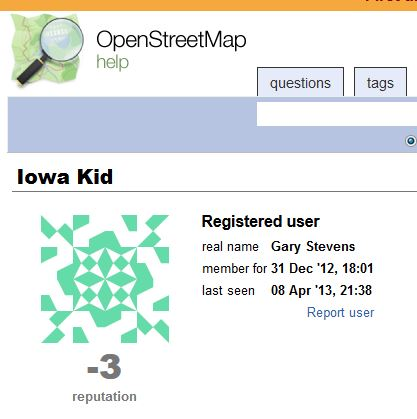

In [44]:
Image("img/IowaKidOSM.jpg")

## Conclusion

##### Overview of the Data

The OSM file for Irving city is quite clean for the most part. While I found slight issue with street name standardization, the zipcodes look legit. This may be due to a large portion of the data being inputted by a nearby city's economic development analyst. 


##### Problems encountered in your map

As noted above, I found issues with street name standardization but not zipcode. When correcting abbreviations such as "Dr" and "St", extra steps need to be taken in order to about corrected results of "DrDrive" and "StStreet".

I did not find the dataset to be useful when it comes to residence unit. My hope in using this dataset for information for house hunting was crushed. Users are very interested in inputting and altering public amenities than residence units.

I also noticed that the hierarchical categorization could be improved. So for eating out places, I had to include expand the _value_ selection to include 'restaurant', 'fast_food', and 'cafe'.
i.e. WHERE value in ('restaurant','fast_food','cafe')

Data input for the OpenStreetMap should be taken with caution since it is an open-sourced information. Like Wikipedia, incorrect or intentionally false information may creep into the site. 

I am not used to SQL queries producing output in tagging format. So, for mst queries, I have utilized _pandas.read_sql_query_ command to obtain output in table format. 

The .db file (mine: irvingtx.db) costed me 20 hours after I forgot to include coding lines on data updating, *update_name()* . I found its solutions but couldn't see the corrected street name updates being reflected in the output. It turned out that I have to manually delete the .db file or create another .db. Otherwise, the .db will keep the old data from *shape_element()*.

##### Other ideas about the datasets

I have established that the Andrew Matheny was involved inclose to 40% of all nodes and ways records, but he is not concerned about residence units. As a researcher myself, i would be interested in seeing how Andrew utilized this map information. Note that Andrew is an analyst of a new, small, but booming city of Allen. My hypotheses are that:
* his team is using this information to figure out what relates to a successful city and
* his team merges this map with other maps and economic data for city planning.


Although I didn't find the dataset to be useful for house hunting, I see great potentials in this dataset utilization. For instance, 
* overlaying this data with house prices and their trend, an analyst may look into factors related to house price trends; 
* the same can be done on economic development to identify what factor drives stimulate and maintain economic growth; and 
* the city government may predict future needs in the city and build the appropiate public facilities.




##### Reference

28 Jupyter Notebook tips, tricks, and shortcuts: https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

Andrew's LinkedIn Profile: https://www.linkedin.com/in/andrewmatheny

Andrew's OSM Profile: http://www.openstreetmap.org/user/Andrew%20Matheny 

Commiting and Pushing a Jupyter Notebook on github: https://stackoverflow.com/questions/48003022/jupyter-notebook-and-github

CSV File Reading and Writing: https://docs.python.org/2/library/csv.html 

How do I check in SQLite whether a table exists?: https://stackoverflow.com/questions/1601151/how-do-i-check-in-sqlite-whether-a-table-exists?rq=1

How to check file size in python?: http://stackoverflow.com/questions/2104080/how-to-check-file-size-in-python

How to Include image or picture in jupyter notebook: https://stackoverflow.com/questions/32370281/how-to-include-image-or-picture-in-jupyter-notebook

Installing Packages: https://packaging.python.org/tutorials/installing-packages/ 

Installing a pip package from within a Jupyter Notebook not working: https://stackoverflow.com/questions/38368318/installing-a-pip-package-from-within-a-jupyter-notebook-not-workinghttps://stackoverflow.com/questions/38368318/installing-a-pip-package-from-within-a-jupyter-notebook-not-working

Keyboard shortcut to paste clipboard content into command prompt window (Win XP): https://stackoverflow.com/questions/131955/keyboard-shortcut-to-paste-clipboard-content-into-command-prompt-window-win-xp

OSM XML: https://wiki.openstreetmap.org/wiki/OSM_XML

Printing a properly formatted SQLite table in Python: https://stackoverflow.com/questions/37051516/printing-a-properly-formatted-sqlite-table-in-python

Problem with SCHEMA: https://discussions.udacity.com/t/problem-with-schema/319234/4

Python BeautifulSoup give multiple tags to findAll: https://stackoverflow.com/questions/20648660/python-beautifulsoup-give-multiple-tags-to-findall

Rubric: https://review.udacity.com/#!/rubrics/25/view

Shortcuts: https://shortcutworld.com/Jupyter-Notebook/win/Jupyter-Notebook_Shortcuts

Street suffix: https://en.wikipedia.org/wiki/Street_suffix

To parse XML: https://pythonprogramming.net/tables-xml-scraping-parsing-beautiful-soup-tutorial/

Updating postal code: https://discussions.udacity.com/t/updating-postal-code/245757/8

UTF-8: Inserting newlines in xml file generated via xml.etree.ElementTree in python: http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python

